In [1]:
%load_ext autoreload
%autoreload 2
from sound_field import SoundField,divide_to_time_windows,divide_to_subbands
from signal_info import signal_info
from optimizer import optimizer
from optimizer_v2 import optimizer_v2
from DoA_est import DoA_via_bands
import utils
import numpy as np
import math
import time
import torch
import gc
import os
from collections import defaultdict,Counter
import matplotlib.pyplot as plt
import sounddevice as sd
import IPython.display as ipd

LEBEDEV = 'lebedev'
POINTS_162 = '162_points'
SQP_OPT_METHOD = "SQP"
GD_DEEP_OPT_METHOD = "GD_Deep"
GD_OPT_METHOD = "GD_lagrange_multi" #GD_Deep GD_lagrange_multi
GD_STFT_OPT_METHOD = "GD_STFT_lagrange_multi" #GD_Deep GD_lagrange_multi
SLS_OPT_METHOD = "SLS"
if torch.cuda.is_available():
    DEVICE = torch.device("cuda:0")
    print("Device Name:", torch.cuda.get_device_name(DEVICE))
else:
    DEVICE = torch.device("cpu")
    print("Device Name: CPU")
torch.set_grad_enabled(False)
torch.cuda.empty_cache()  # Free up unused memory on GPU
gc.collect()  # Clean up unused memory on CPU


# Notes:
# 1) Do we really need such a high # of iter? Maybe some windows/freqs we can stop early?
# 2) Diff # of iter in localization and sound field creation?
# 3) Add mask creatiion to class? (add mask detauils to sound_field)
# 4) Sparse Attention


Device Name: NVIDIA GeForce RTX 4080 SUPER


56

In [2]:
def mem_status():
    gc.collect() 
    gpu_tensors = [obj for obj in gc.get_objects() if isinstance(obj, torch.Tensor) and obj.device.type == 'cuda']
    print(f"GPU Tensors: {len(gpu_tensors)}")
    for tensor in gpu_tensors:
        num_elements = tensor.numel()
        element_size = tensor.element_size()
        memory_size_bytes = num_elements * element_size / 1e6
        print(f"Tensor on device: {tensor.device} : {memory_size_bytes}  MB")

In [3]:
mem_status()

GPU Tensors: 0


C:\Users\amitmils\AppData\Local\Temp\ipykernel_35140\3564447253.py:3: FutureWarning: `torch.distributed.reduce_op` is deprecated, please use `torch.distributed.ReduceOp` instead
  gpu_tensors = [obj for obj in gc.get_objects() if isinstance(obj, torch.Tensor) and obj.device.type == 'cuda']


In [33]:
signals = [
    signal_info(
        signal_path=r"data/sound_files/male_speech.wav",
        th=90,
        ph=90,
        in_rad=False,
    ),
    signal_info(
        signal_path=r"data/sound_files/female_speech.wav",
        th=90,
        ph=45,
        in_rad=False,
    ),
]

### Encode Sound Field

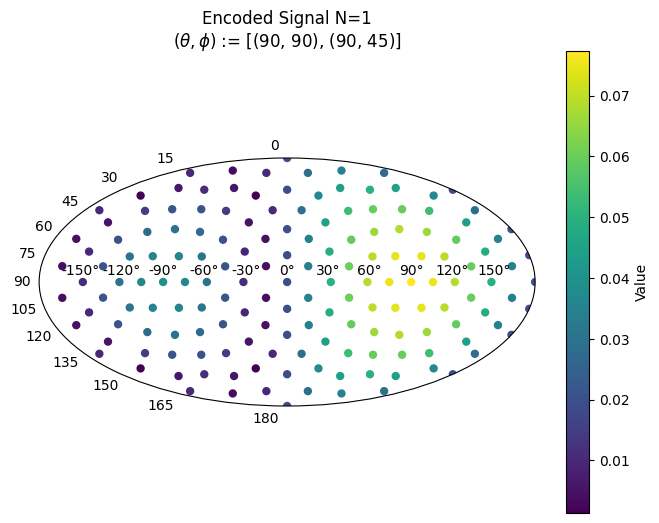

In [34]:
sound_field = SoundField(DEVICE)
input_order = 1
upscale_order = 3
anm_f = sound_field.create(
    signals=signals,
    order=input_order,
    SH_type='complex',
    debug=True,
    grid_type=POINTS_162,
)
Y_p = utils.create_sh_matrix(input_order, zen=sound_field.P_th, azi=sound_field.P_ph)

### Sanity Check, Play the audio from anm_f

In [46]:
n_fft = int(2*anm_f.shape[1]-1)      # Extract # FFT points from size of anm_f
hop_length = n_fft//2   # Hop length (stride)
win_length = n_fft   # Window length
mono_signal = torch.istft(anm_f[3],#torch.sum(anm_f, dim=0),
            n_fft=n_fft,
            hop_length= hop_length,
            win_length=win_length,
            window = torch.hann_window(win_length)
            )
mono_signal_np = mono_signal.numpy()
sd.play(mono_signal_np, samplerate=sound_field.sr)


### Plot Spectograms

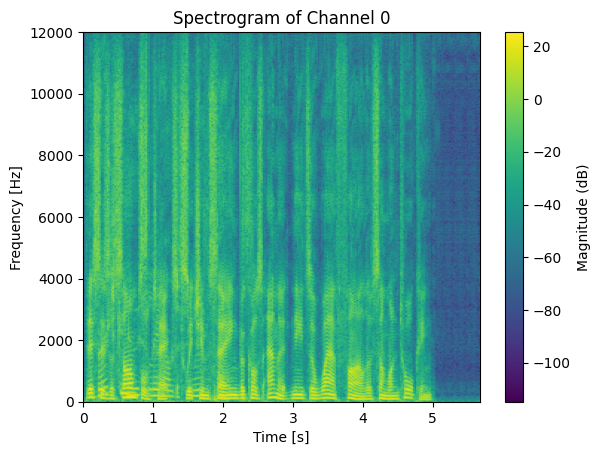

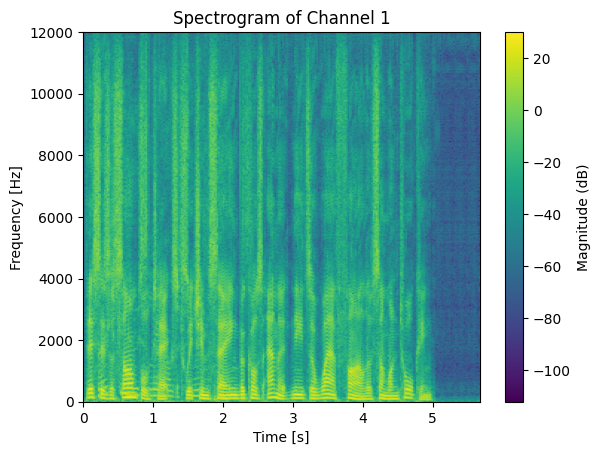

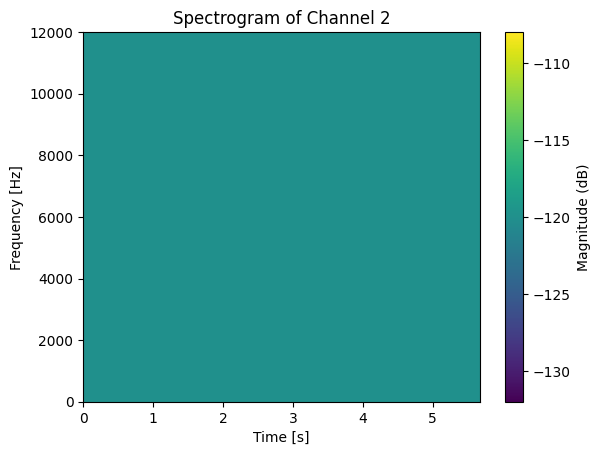

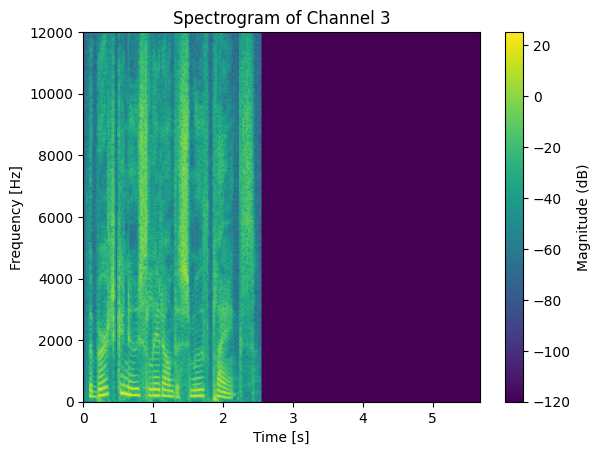

In [ ]:
for channel_id in range(anm_f.shape[0]):
    plt.figure()
    magnitude = torch.abs(anm_f[channel_id]).t()
    freq_bins, time_frames = magnitude.shape
    sr = sound_field.sr
    time_axis = (torch.arange(time_frames) * hop_length) / sr  # Time in seconds
    freq_axis = torch.arange(freq_bins) * (sr / n_fft) 
    plt.imshow(20*torch.log10(magnitude + 1e-6),
        aspect='auto', 
        origin='lower', 
        extent=[time_axis[0], time_axis[-1], freq_axis[0], freq_axis[-1]],
    )
    plt.colorbar(label='Magnitude (dB)')
    plt.xlabel('Time [s]')
    plt.ylabel('Frequency [Hz]')
    plt.title(f'Spectrogram of Channel {channel_id}')


### Create Mask


In [9]:
mask_type = None # "cheat" None , 'algo'

if mask_type is None:
    mask = None
    sound_field.has_mask = False
else:
    sound_field.has_mask = True
    if mask_type == "cheat":
        target_th = torch.tensor([math.radians(coo[0]) for coo in sound_field.sources_coords])
        target_ph = torch.tensor([math.radians(coo[1]) for coo in sound_field.sources_coords])
        mask = torch.any(torch.sqrt((sound_field.P_th[...,None] - target_th)**2 + (sound_field.P_ph[...,None] - target_ph)**2) < math.radians(10),dim=1)
    elif mask_type == "algo":
        pass
    dummy = torch.zeros_like(mask)
    dummy[mask] = 1
    utils.plot_on_2D(
        azi=sound_field.P_ph,
        zen=sound_field.P_th,
        values=dummy,
        title=f"Spatial Mask\n$(\\theta,\\phi)$ := {[tuple((round(th),round(phi))) for (th,phi) in sound_field.sources_coords]}",
    )



### Find Sparse Dict -- Complex?


In [45]:
if True:
    opt = optimizer(Y_p, alpha=0.1, method=GD_STFT_OPT_METHOD,device=DEVICE , save_loss=False)
    opt.P_th = sound_field.P_th
    opt.P_ph = sound_field.P_ph
    print(f"Method : {opt.method}")
    start = time.time()
    with torch.no_grad():
        s_dict_subbands, s_windowed, s_dict = sound_field.get_sparse_dict_v3(stft_anm,opt,mask,iter = 1e5,multi_processing=False,save=True) #single processing progress bar doesnt work
    print(f"Time: {time.time()-start}")
    real_anmt = sound_field.anm_t_windowed.sum(dim=1).squeeze().reshape(-1,4)
    print(f"{real_anmt.shape=}")
    est_anmt = (Y_p.cpu() @ s_dict.cpu()).t()
    print(f"{est_anmt.shape=}")

c:\Users\amitmils\Documents\Repo\AmbisonicUpscaling\optimizer.py:205: UserWarning: ComplexHalf support is experimental and many operators don't support it yet. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\EmptyTensor.cpp:47.)
  lagrange_multi_t = torch.zeros(


Method : GD_STFT_lagrange_multi


  0%|          | 0/100000 [00:00<?, ?it/s]

Value(False)
Value(False)
Value(False)
Value(False)


  0%|          | 0/100000 [00:03<?, ?it/s]


RuntimeError: "baddbmm_cuda" not implemented for 'ComplexHalf'

#### Plot Loss Per Freq

In [29]:
opt.save_loss

True

In [37]:
loss_per_freq = opt.reconstruction_loss.squeeze()
from_iter = int(1e5-1000)
to_iter = int(1e5)
plt.figure()
for i in range(loss_per_freq.shape[1]):
    plt.plot(range(from_iter,to_iter),loss_per_freq[from_iter:to_iter].cpu())
plt.title("Reconstruction Loss Per Freq")
plt.xlabel("Iteration")
plt.ylabel("Loss")


Text(0, 0.5, 'Loss')

: 

### Loss Per Time Stamp

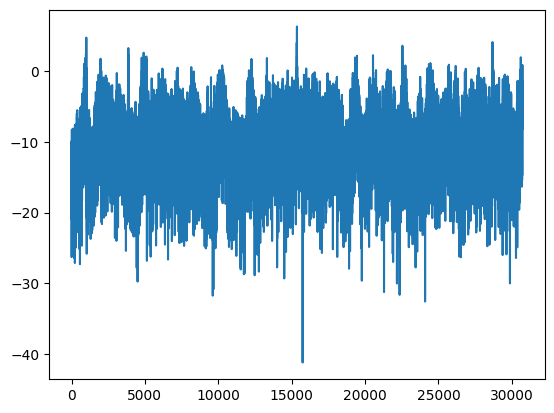

In [11]:
loss = 10*torch.log10(torch.norm(real_anmt- est_anmt,dim=1)**2)
plt.figure()
plt.plot(loss.cpu())

Average Loss -10.135308265686035
Signal 0 : 0.0123291015625 | Phi = 90.0 | Theta = 90.0
Signal 1 : 0.00108265969902277 | Phi = -90.0 | Theta = 90.0
Loss in time_index=1000 -44.83824157714844


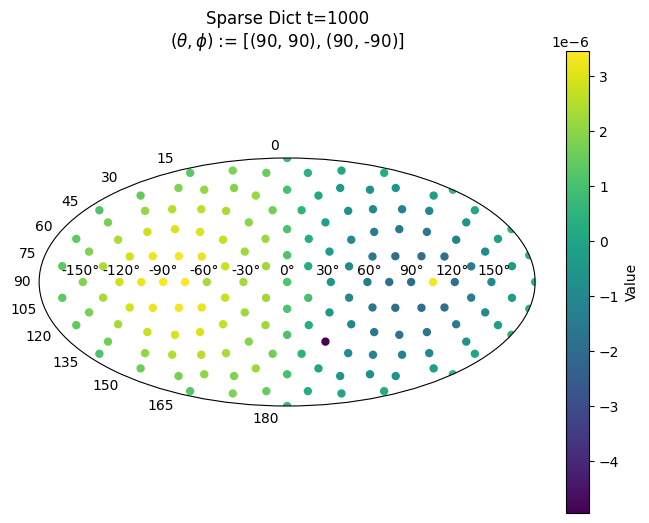

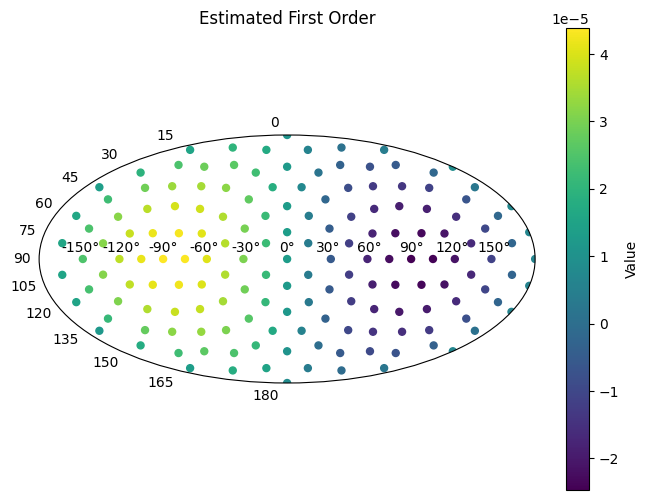

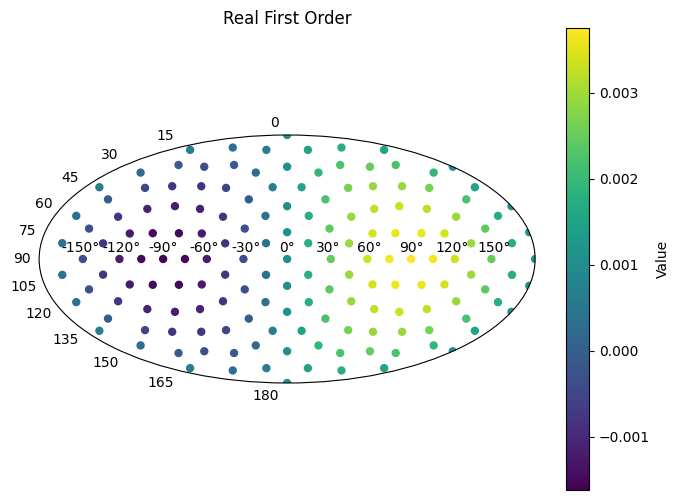

In [19]:
print(f"Average Loss {torch.mean(loss)}")

time_index = 1000

for i,sig in enumerate(sound_field.signals):
    print(f"Signal {i} : {sig.signal.squeeze()[time_index]} | Phi = {math.degrees(sig.ph)} | Theta = {math.degrees(sig.th)}")
sound_field.plot_sparse_dict(sound_field.s_dict,time_index)
print(f"Loss in {time_index=} {10*torch.log10(torch.norm(real_anmt[time_index,:] - est_anmt[time_index,:],p=2)**2)}")
utils.plot_on_2D(
            azi=sound_field.P_ph,
            zen=sound_field.P_th,
            values=torch.conj(Y_p).cpu().t() @ est_anmt[time_index,:],
            title=f"Estimated First Order",
)
utils.plot_on_2D(
            azi=sound_field.P_ph,
            zen=sound_field.P_th,
            values=torch.conj(Y_p).cpu().t() @ anm_t[time_index,:],
            title=f"Real First Order",
)


In [101]:
sound_field.play_sparse_sound_field(phi=-90,theta=90,radius=10)

torch.Size([162, 30720])
## Playing Directions ##
Theta = -90.0, Phi = 90.0


In [30]:
Y_p = utils.create_sh_matrix(
    input_order, zen=sound_field.P_th, azi=sound_field.P_ph
).to(DEVICE)

Y_p_tag = utils.create_sh_matrix(
    upscale_order, zen=sound_field.P_th, azi=sound_field.P_ph
).to(
    DEVICE
)  # upscaling matrix
opt_v2 = optimizer_v2(Y_p=Y_p, alpha=0.01, num_iters=1e2, device=DEVICE)
s_dict_subbands = opt_v2.forward(sound_field.anm_t_windowed, mask, upscale_order)


100%|██████████| 100/100 [00:00<00:00, 1388.19it/s]


In [31]:
s_dict_windowed = torch.sum(s_dict_subbands, axis=1)
s_dict = s_dict_windowed.permute(1, 0, 2).reshape(
    sound_field.num_grid_points, sound_field.window_length * sound_field.num_windows)
sound_field.est_anm_upscaled = torch.matmul(Y_p_tag, s_dict)
sound_field.est_anm_upscaled.shape

torch.Size([16, 2048])

In [65]:
torch.conj(Y_p).cpu().shape

torch.Size([4, 162])

In [2]:
sound_field = torch.load("data/output\sound_field_1_order_30_win_45_bin_2702_points_NOmask_24Y_11M_21F_21H_12m.pt")

<>:1: SyntaxWarning: invalid escape sequence '\s'
<>:1: SyntaxWarning: invalid escape sequence '\s'
C:\Users\amitmils\AppData\Local\Temp\ipykernel_26636\229298355.py:1: SyntaxWarning: invalid escape sequence '\s'
  sound_field = torch.load("data/output\sound_field_1_order_30_win_45_bin_2702_points_NOmask_24Y_11M_21F_21H_12m.pt")
C:\Users\amitmils\AppData\Local\Temp\ipykernel_26636\229298355.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly all

## Direction 

In [ ]:
doa_estimator = DoA_via_bands(sound_field, DEVICE)

1/30
2/30


: 

In [ ]:
doa_estimator.normalized_abs_sound_field[10,40].shape


torch.Size([30, 2702, 1024])

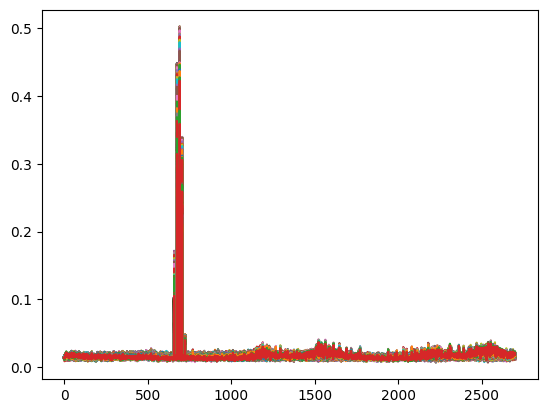

In [ ]:
doa_estimator.normalized_abs_sound_field.shape
tmp = doa_estimator.normalized_abs_sound_field.sum(dim=1)
for i in range(doa_estimator.normalized_abs_sound_field.shape[1]):
    plt.figure()
    plt.plot(doa_estimator.normalized_abs_sound_field[10,i])
    plt.title(f"Bin : {i}")
plt.show()

In [12]:
est = doa_estimator._get_window_candidates()

In [14]:
est[0]

[]

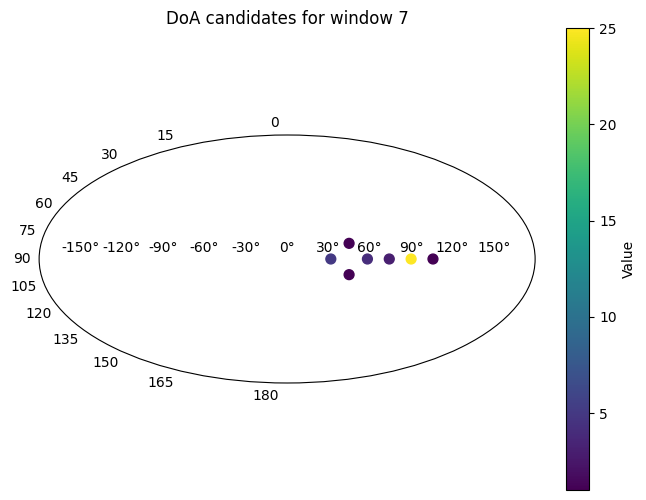

In [254]:
doa_estimator.plot_window_candidates(est,window=7)

In [102]:
def show_candidates(window_dir_candidates,window_num = None):
    if window_num is None:
        for window_num in range(len(window_dir_candidates)):
            th = window_dir_candidates[window_num][:,0].numpy()
            phi = window_dir_candidates[window_num][:,1].numpy()
            prob = window_dir_candidates[window_num][:,2].numpy()
            if len(th) == 0:
                print(f"Window {window_num} No candidates")
                continue
            plt.figure()
            plt.title(f"Window {window_num} DoA candidates\n({th@prob:.2f},{phi@prob:.2f})")
            plt.xlim(-180,180)
            plt.ylim(0,180)
            plt.scatter(th,phi,c=prob,cmap='viridis')
            plt.colorbar()
    else:
        plt.figure()
        plt.title(f"Window {window_num} DoA candidates\n({th@prob:.2f},{phi@prob:.2f})")
        plt.xlim(-180,180)
        plt.ylim(0,180)
        plt.scatter(th,phi,c=prob,cmap='viridis')
        plt.colorbar()

In [49]:
sound_field.play_sparse_sound_field(theta=90,phi=0,radius = 20)

torch.Size([162, 30720])
## Playing Directions ##
Theta = 0.0, Phi = 90.0
Theta = -15.450437086325833, Phi = 80.65029645742543
Theta = 0.0, Phi = 74.1412627942695
Theta = 0.0, Phi = 105.8587372057305
Theta = -15.450437086325833, Phi = 99.34970354257459
Theta = 15.450437086325833, Phi = 80.65029645742543
Theta = 15.450437086325833, Phi = 99.34970354257459
